## Exact solutions, decoupling


In [1]:
#!/usr/bin/env python
# coding: utf-8

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

import argparse
import os
import datetime
import pathlib
import random
import json
import numpy as np
import math

import torch
from scipy.stats import ortho_group

import sys
sys.path.append('../code/')
from linear_utils import linear_model, get_modulation_matrix
from train_utils import save_config

In [58]:
# argument written in command line format
cli_args = '--seed 12 --save-results --risk-loss L2 -t 100000 -w 0.1 0.1 --lr 0.001 0.001 -d 2 -n 50 --hidden 50 --sigmas 1 --kappa 5.0'
sigma_noise = 0.0
transform_data = True
cont_eigs = False

#cli_args = '--seed 12 --save-results --jacobian --risk-loss L2 -t 20000 -w 0.1 0.1 --lr 0.00001 -d 50 -n 1000 --hidden 50 --sigmas 1 --kappa 3'
#sigma_noise = 1.0



In [60]:

# get CLI parameters
parser = argparse.ArgumentParser(description='CLI parameters for training')
parser.add_argument('--root', type=str, default='', metavar='DIR',
                    help='Root directory')
parser.add_argument('-t', '--iterations', type=int, default=1e4, metavar='ITERATIONS',
                    help='Iterations (default: 1e4)')
parser.add_argument('-n', '--samples', type=int, default=100, metavar='N',
                    help='Number of samples (default: 100)')
parser.add_argument('--print-freq', type=int, default=1000,
                    help='CLI output printing frequency (default: 1000)')
parser.add_argument('--gpu', type=int, default=None,
                    help='Number of GPUS to use')
parser.add_argument('--seed', type=int, default=None,
                    help='Random seed')                        
parser.add_argument('-d', '--dim', type=int, default=50, metavar='DIMENSION',
                    help='Feature dimension (default: 50)')
parser.add_argument('--hidden', type=int, default=200, metavar='DIMENSION',
                    help='Hidden layer dimension (default: 200)')
parser.add_argument('--sigmas', type=str, default=None,
                    help='Sigmas')     
parser.add_argument('-r','--s-range', nargs='*', type=float,
                    help='Range for sigmas')
parser.add_argument('--kappa', type=float,
                    help='Eigenvalue ratio')
parser.add_argument('-w','--scales', nargs='*', type=float,
                    help='scale of the weights')
parser.add_argument('--lr', type=float, default=1e-4, nargs='*', metavar='LR',
                    help='learning rate (default: 1e-4)')              
parser.add_argument('--normalized', action='store_true', default=False,
                    help='normalize sample norm across features')
parser.add_argument('--risk-loss', type=str, default='MSE', metavar='LOSS',
                    help='Loss for validation')
parser.add_argument('--jacobian', action='store_true', default=False,
                    help='compute the SVD of the jacobian of the network')
parser.add_argument('--save-results', action='store_true', default=False,
                    help='Save the results for plots')
parser.add_argument('--details', type=str, metavar='N',
                    default='no_detail_given',
                    help='details about the experimental setup')


args = parser.parse_args(cli_args.split())

# directories
root = pathlib.Path(args.root) if args.root else pathlib.Path.cwd().parent

current_date = str(datetime.datetime.today().strftime('%Y-%m-%d-%H-%M-%S'))
args.outpath = (pathlib.Path.cwd().parent / 'results' / 'two_layer_nn' /  current_date)

if args.save_results:
    args.outpath.mkdir(exist_ok=True, parents=True)

if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [26]:
zero_eigs = 0 if args.samples >= args.dim else (args.dim - args.samples)
p = int(np.ceil((args.dim - zero_eigs) / 2))

d_out = 2      # dimension of y
#beta = np.ones((args.dim, d_out))

share_v = True


Ux = ortho_group.rvs(args.samples)
Sx = get_modulation_matrix(args.dim, p, args.kappa, diag_sorted=True)[::-1]
Uyx = ortho_group.rvs(d_out) if d_out > 1 else np.ones((1, 1))
Vx = np.eye(args.dim) #ortho_group.rvs(args.dim)

if share_v:
    Xs = Ux[:, :args.dim] @ np.diag(Sx) @ Vx.T
    
    Sw = np.array([0.2, 5.0])
    beta_raw = Uyx @ np.diag(Sw) @ Vx.T[:d_out, :]
    ys = Xs @ beta_raw.T
    
    print(Vx.T)
    Vyx = Vx.copy()

    Syx = Sw * Sx[:d_out]**2
    print(Syx)
    print(np.linalg.svd(ys.T @ Xs))
    print(ys.T @ Xs)
    print(Uyx @ np.diag(Syx) @ Vx.T[:d_out, :])
else:
    Syx = np.array([5.0, 5.0])
    Vyx = ortho_group.rvs(args.dim)
    
    Xs = Ux[:, :args.dim] @ np.diag(Sx) @ Vx.T

    beta_raw = Uyx @ np.diag(Syx) @ Vyx.T[:d_out, :] @ np.linalg.inv(Xs.T @ Xs)
                    

[[1. 0.]
 [0. 1.]]
[5. 5.]
(array([[-0.9823501 , -0.18705153],
       [ 0.18705153, -0.9823501 ]]), array([5., 5.]), array([[-0., -1.],
       [-1., -0.]]))
[[ 0.93525766  4.91175051]
 [ 4.91175051 -0.93525766]]
[[ 0.93525766  4.91175051]
 [ 4.91175051 -0.93525766]]


In [27]:
np.linalg.svd(Xs)

(array([[-0.07794141, -0.177651  , -0.11544249, ..., -0.0874675 ,
          0.08586686,  0.30973408],
        [-0.11202836, -0.08748856, -0.02082787, ...,  0.03503588,
         -0.28257445,  0.05125015],
        [-0.11490045, -0.02776642,  0.98762176, ..., -0.0089589 ,
          0.00674498,  0.03317276],
        ...,
        [-0.0901762 ,  0.02926464, -0.00929297, ...,  0.99086143,
          0.01921546,  0.02512435],
        [ 0.10376063, -0.27439807,  0.0087045 , ...,  0.02045165,
          0.91224978, -0.02461718],
        [ 0.30856406,  0.06991324,  0.03320321, ...,  0.0242511 ,
         -0.01938241,  0.91099783]]),
 array([5., 1.]),
 array([[1., 0.],
        [0., 1.]]))

In [28]:
Xs = torch.tensor(Xs, dtype=torch.float32).to(device)

if share_v:
    ys = torch.tensor(ys.reshape((-1, d_out)), dtype=torch.float32).to(device)

In [29]:
# define loss functions
loss_fn = torch.nn.MSELoss(reduction='sum')
risk_fn = torch.nn.L1Loss(reduction='sum') if args.risk_loss == 'L1' else torch.nn.MSELoss(reduction='sum')

## Two layer, diagonal

In [30]:
def diagonal_init(model, X, y, Uyx, Vhyx, g_cpu, args, synaptic=False, fixed=False):
        
    if args.hidden > 1:
        R = torch.tensor(ortho_group.rvs(dim=args.hidden), dtype=torch.float32)
    else:
        R = torch.tensor([[1]], dtype=torch.float32)
    
    i = 0
    w_check = None
    with torch.no_grad(): 
        p, q, u = 0, 0, 0
        for m in model:
            if type(m) == torch.nn.Linear:
                     
                
                if i == 0:
                    D = torch.zeros(m.weight.data.shape, dtype=torch.float32).fill_diagonal_(1, wrap=False)
                    
                    if fixed:
                        D[D == 1] = torch.ones(min(m.weight.data.shape[0], m.weight.data.shape[1]),) * args.scales[0]
                    else:
                        D[D == 1] = torch.normal(mean=0, std=args.scales[0], size=(min(m.weight.data.shape[0], m.weight.data.shape[1]),), generator=g_cpu)
 
                    
                    if synaptic:
                        m.weight.data = torch.matmul(R, D)
                    else:
                        m.weight.data = torch.matmul(torch.matmul(R, D), Vhyx)
                    
                    w_check = m.weight.data.clone()
                     
                else:
                    
                    if i == 1:
                        D = torch.zeros(m.weight.data.shape, dtype=torch.float32).fill_diagonal_(1, wrap=False)
                        
                        if fixed:
                            D[D == 1] = torch.ones(min(m.weight.data.shape[0], m.weight.data.shape[1]),) * args.scales[1]
                        else:
                            D[D == 1] = torch.normal(mean=0, std=args.scales[1], size=(min(m.weight.data.shape[0], m.weight.data.shape[1]),), generator=g_cpu)
                        
                        if synaptic: 
                            m.weight.data = torch.matmul(D, R.T)
                        else:
                            m.weight.data = torch.matmul(Uyx, torch.matmul(D, R.T))
                        
                        w_check = m.weight.data.clone() @ w_check
                        
                    else:
                        print("Initialisation only supported for two layers.")
               
                i += 1
   
        print("Initial weight: \n {}".format(w_check))
        w_check = (Uyx.T @ w_check @ Vhyx).numpy()
        print("Transformed initial weight: \n {}".format(w_check))

        #assert np.count_nonzero(w_check - np.diag(np.diagonal(w_check))) == 0
    
    return model

def tuned_initialisation(args, fixed=False):
    
    i = 0
    for m in model:
        
        if type(m) == torch.nn.Linear:
            if fixed:
                m.weight.data = torch.ones(m.weight.data.shape) * args.scales[i]
            else:
                m.weight.data = m.weight.data.uniform_(-args.scales[i], args.scales[i])
        
        i += 1
        
    return model

In [57]:
model = torch.nn.Sequential(
           torch.nn.Linear(args.dim, args.hidden, bias=False),
           #torch.nn.ReLU(),
           torch.nn.Linear(args.hidden, d_out, bias=False),
         ).to(device)      
                
# initialization 
synaptic = True

Sx_tens, Syx_tens = torch.tensor(np.diag(Sx), dtype=torch.float32), torch.tensor(np.diag(Syx), dtype=torch.float32)

if d_out < args.dim:
    Syx_tens = torch.cat((Syx_tens, torch.zeros((d_out, args.dim - d_out))), dim=1)

if synaptic: 
    beta = Uyx.T @ beta_raw @ Vyx - np.random.randn(d_out * args.dim).reshape(d_out, args.dim) * np.linalg.inv(np.diag(Sx))**0.5
    print(Uyx.T @ beta_raw @ Vyx)
    print(beta)
else:
    beta = beta_raw


g_cpu = torch.Generator()
g_cpu.manual_seed(args.seed)

Uyx_tens, Vyx_tens = torch.tensor(Uyx, dtype=torch.float32), torch.tensor(Vyx, dtype=torch.float32)
model = diagonal_init(model, Xs, ys, Uyx_tens, Vyx_tens.T, g_cpu, args, synaptic=synaptic, fixed=True)
#model = tuned_initialisation(args, fixed=False)

VXXV = Vyx_tens.T @ Xs.T @ Xs @ Vyx_tens
print(VXXV)

# use same learning rate for the two layers
#if isinstance(args.lr, list):
#    stepsize = [max(args.lr)] * 2
stepsize = args.lr

[[ 2.00000000e-01 -9.99200722e-16]
 [-4.85722573e-17  5.00000000e+00]]
[[ 1.59843572e-01 -9.99200722e-16]
 [-4.85722573e-17  2.39116944e+00]]
Initial weight: 
 tensor([[2.5000e-01, 7.4506e-09],
        [7.4506e-09, 2.5000e-01]])
Transformed initial weight: 
 [[ 0.04676289  0.24558759]
 [ 0.24558753 -0.04676289]]
tensor([[2.5000e+01, 5.9605e-08],
        [5.9605e-08, 1.0000e+00]])


In [46]:
np.linalg.svd(Xs.T@Xs)

(array([[-1.0000000e+00, -2.4835267e-09],
        [-2.4835267e-09,  1.0000000e+00]], dtype=float32),
 array([25.000002,  1.      ], dtype=float32),
 array([[-1.0000000e+00, -2.4835267e-09],
        [-2.4835267e-09,  1.0000000e+00]], dtype=float32))

In [62]:
Wtot = torch.diag(torch.ones(args.dim))
for param in model.parameters():
    if len(param.shape) > 1:
        Wtot = Wtot @ param.data.t()
        #print(param.data.t())
        
print(Wtot)

tensor([[ 1.0000e-02, -1.3097e-10],
        [-1.4552e-11,  1.0000e-02]])


In [63]:
Syx_tens

tensor([[5., 0.],
        [0., 5.]])

In [64]:
# train the network
losses_emp = []
mse_weights_emp = []
ws = []


for t in range(int(args.iterations)):
    
    if share_v:
                
        if synaptic:
            y_pred = Xs @ torch.matmul(Uyx_tens, torch.matmul(torch.matmul(model[1].weight, model[0].weight),  Vyx_tens.T)).T
        else:
            y_pred = model(Xs)


        loss = loss_fn(y_pred, ys)
        losses_emp.append(loss.item())

        if not t % args.print_freq:
            print(t, loss.item())
        
        model.zero_grad()
        loss.backward()
    else:
        assert synaptic


    with torch.no_grad():
        i = 0
        w_tot = torch.diag(torch.ones(args.dim)) #[]
        for param in model.parameters():
                
                
            if synaptic:
                
                if synaptic: 
                    grad_diff = Syx_tens - torch.matmul(torch.matmul(model[1].weight, model[0].weight), VXXV)

                if i == 0:
                    grad = - torch.matmul(model[1].weight.T, grad_diff)
                    param.data -= stepsize[i] * grad
                elif i == 1:
                    grad = - torch.matmul(grad_diff, model[0].weight.T)
                    param.data -= stepsize[i] * grad

                else:
                    print("Training in synaptic weight space and manual gradients only supported for two layers.")
            else:
                param.data -= stepsize[i] * param.grad
                                
            w_tot = w_tot @ param.data.t()
            if len(param.shape) > 1:
                i += 1

        w_tot = w_tot.T.squeeze()
        ws.append(w_tot)
        assert w_tot.shape == beta.squeeze().shape
        mse_weights_emp.append((w_tot-beta.squeeze())**2)


0 25.802600860595703
1000 0.012042402289807796
2000 8.942757090402154e-10
3000 8.943417117990293e-10
4000 8.945081342304206e-10
5000 8.945081342304206e-10
6000 8.945081342304206e-10
7000 8.945081342304206e-10
8000 8.945081342304206e-10
9000 8.945081342304206e-10
10000 8.945081342304206e-10
11000 8.945081342304206e-10
12000 8.945081342304206e-10
13000 8.945081342304206e-10
14000 8.945081342304206e-10
15000 8.945081342304206e-10
16000 8.945081342304206e-10
17000 8.945081342304206e-10
18000 8.945081342304206e-10
19000 8.945081342304206e-10
20000 8.945081342304206e-10
21000 8.945081342304206e-10
22000 8.945081342304206e-10
23000 8.945081342304206e-10
24000 8.945081342304206e-10
25000 8.945081342304206e-10
26000 8.945081342304206e-10
27000 8.945081342304206e-10
28000 8.945081342304206e-10
29000 8.945081342304206e-10
30000 8.945081342304206e-10
31000 8.945081342304206e-10
32000 8.945081342304206e-10
33000 8.945081342304206e-10
34000 8.945081342304206e-10
35000 8.945081342304206e-10
36000 8.9

In [65]:
geo_samples = [int(i) for i in np.geomspace(1, args.iterations-1, num=700)]

In [66]:
print(mse_weights_emp[-1])
print(mse_weights_emp[-1].reshape(-1))
print(w_tot)
print(w_tot.reshape(-1))

tensor([[1.6124e-03, 1.5691e-14],
        [1.0495e-16, 6.8058e+00]], dtype=torch.float64)
tensor([1.6124e-03, 1.5691e-14, 1.0495e-16, 6.8058e+00], dtype=torch.float64)
tensor([[ 2.0000e-01, -1.2526e-07],
        [ 1.0245e-08,  5.0000e+00]])
tensor([ 2.0000e-01, -1.2526e-07,  1.0245e-08,  5.0000e+00])


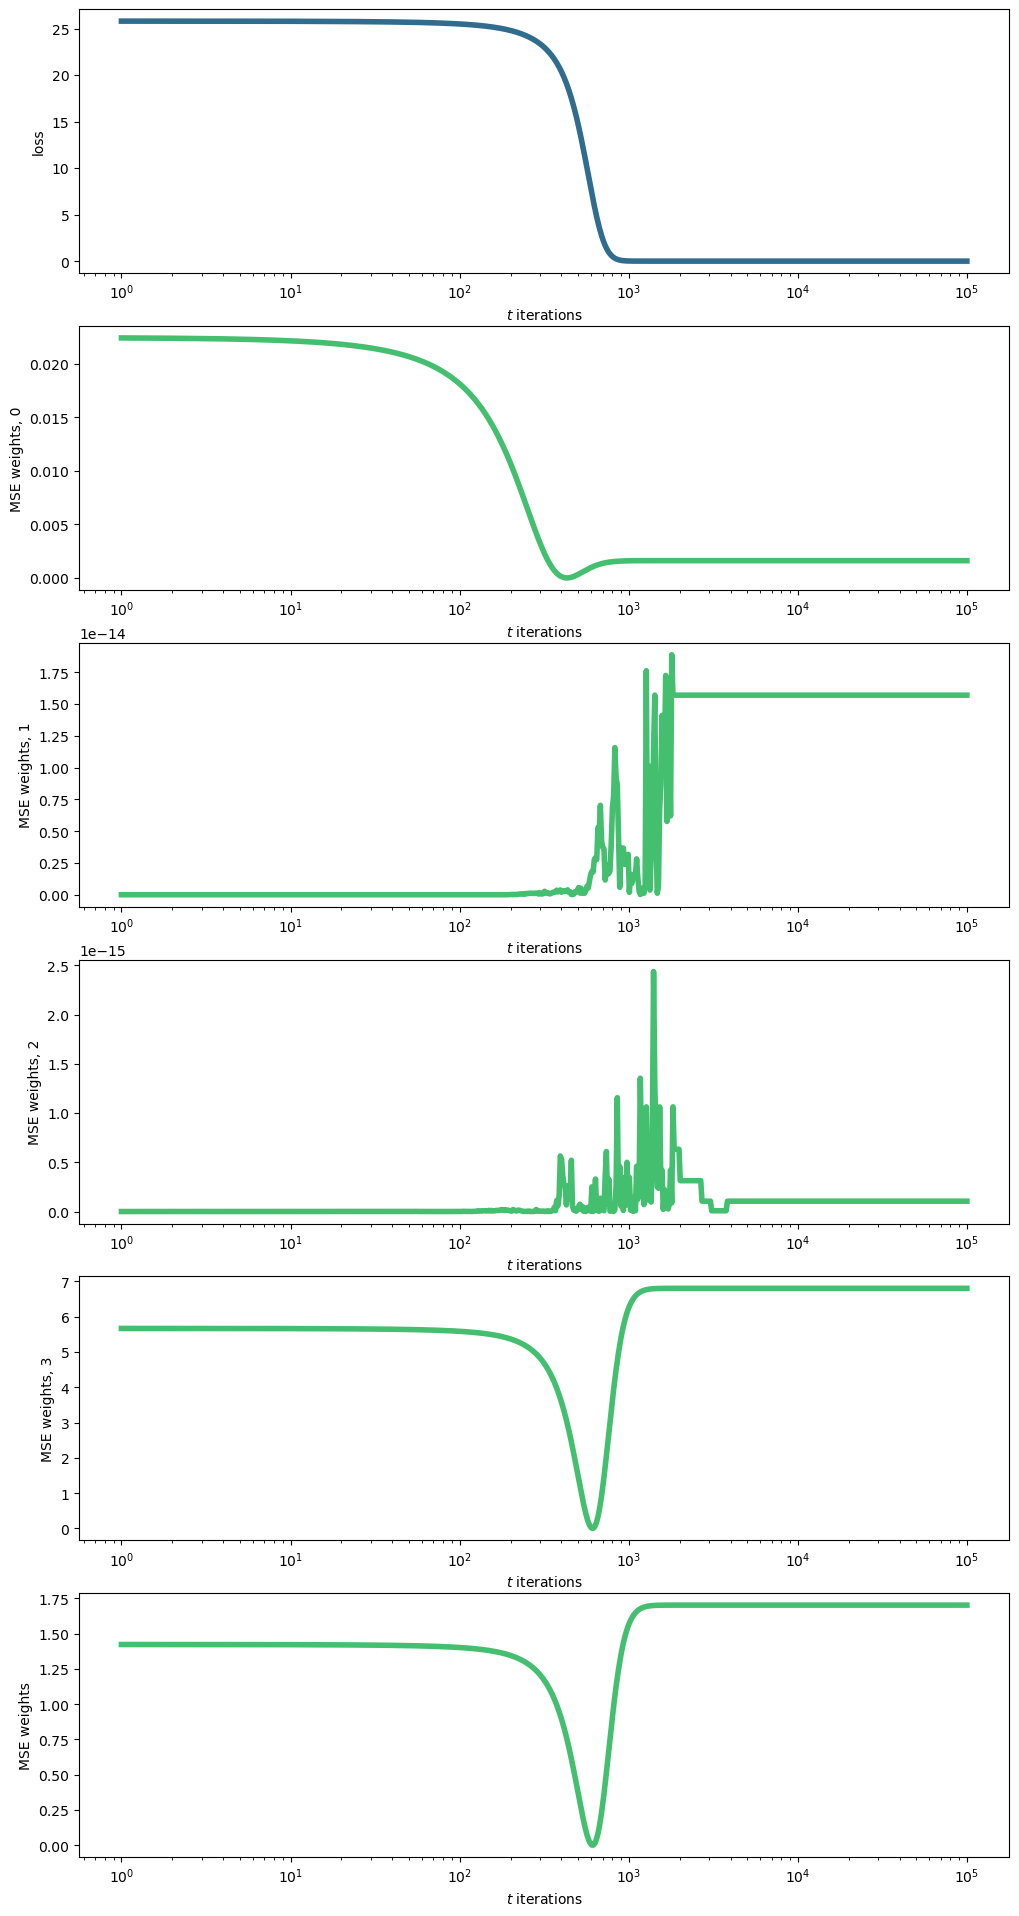

In [70]:
losses = np.array(losses_emp)
risks_w = np.row_stack([mse_w.reshape(-1) for mse_w in mse_weights_emp])

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(700/1000)]
labelList = ['empirical', 'theoretical']

plot_all_dims = True

num_axs = 2 + risks_w.shape[-1] if plot_all_dims else 2

fig, ax = plt.subplots(num_axs, 1, figsize=(12, 4 * num_axs))

if share_v:
    ax[0].set_xscale('log')
    ax[0].plot(geo_samples, losses[geo_samples], 
            color=colorList[1], 
            label=labelList[0],
            lw=4)

ax[0].set_ylabel('loss')
ax[0].set_xlabel(r'$t$ iterations')


if plot_all_dims:
    for i in range(risks_w.shape[-1]):
        ax[1+i].set_xscale('log')
        ax[1+i].plot(geo_samples, risks_w[geo_samples, i], 
                color=colorList[2], 
                label=labelList[0],
                lw=4)

        ax[1+i].set_ylabel('MSE weights, ' + str(i))
        ax[1+i].set_xlabel(r'$t$ iterations')


ax[-1].set_xscale('log')
ax[-1].plot(geo_samples, risks_w[geo_samples, :].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[0],
        lw=4)

ax[-1].set_ylabel('MSE weights')
ax[-1].set_xlabel(r'$t$ iterations')


plt.show()

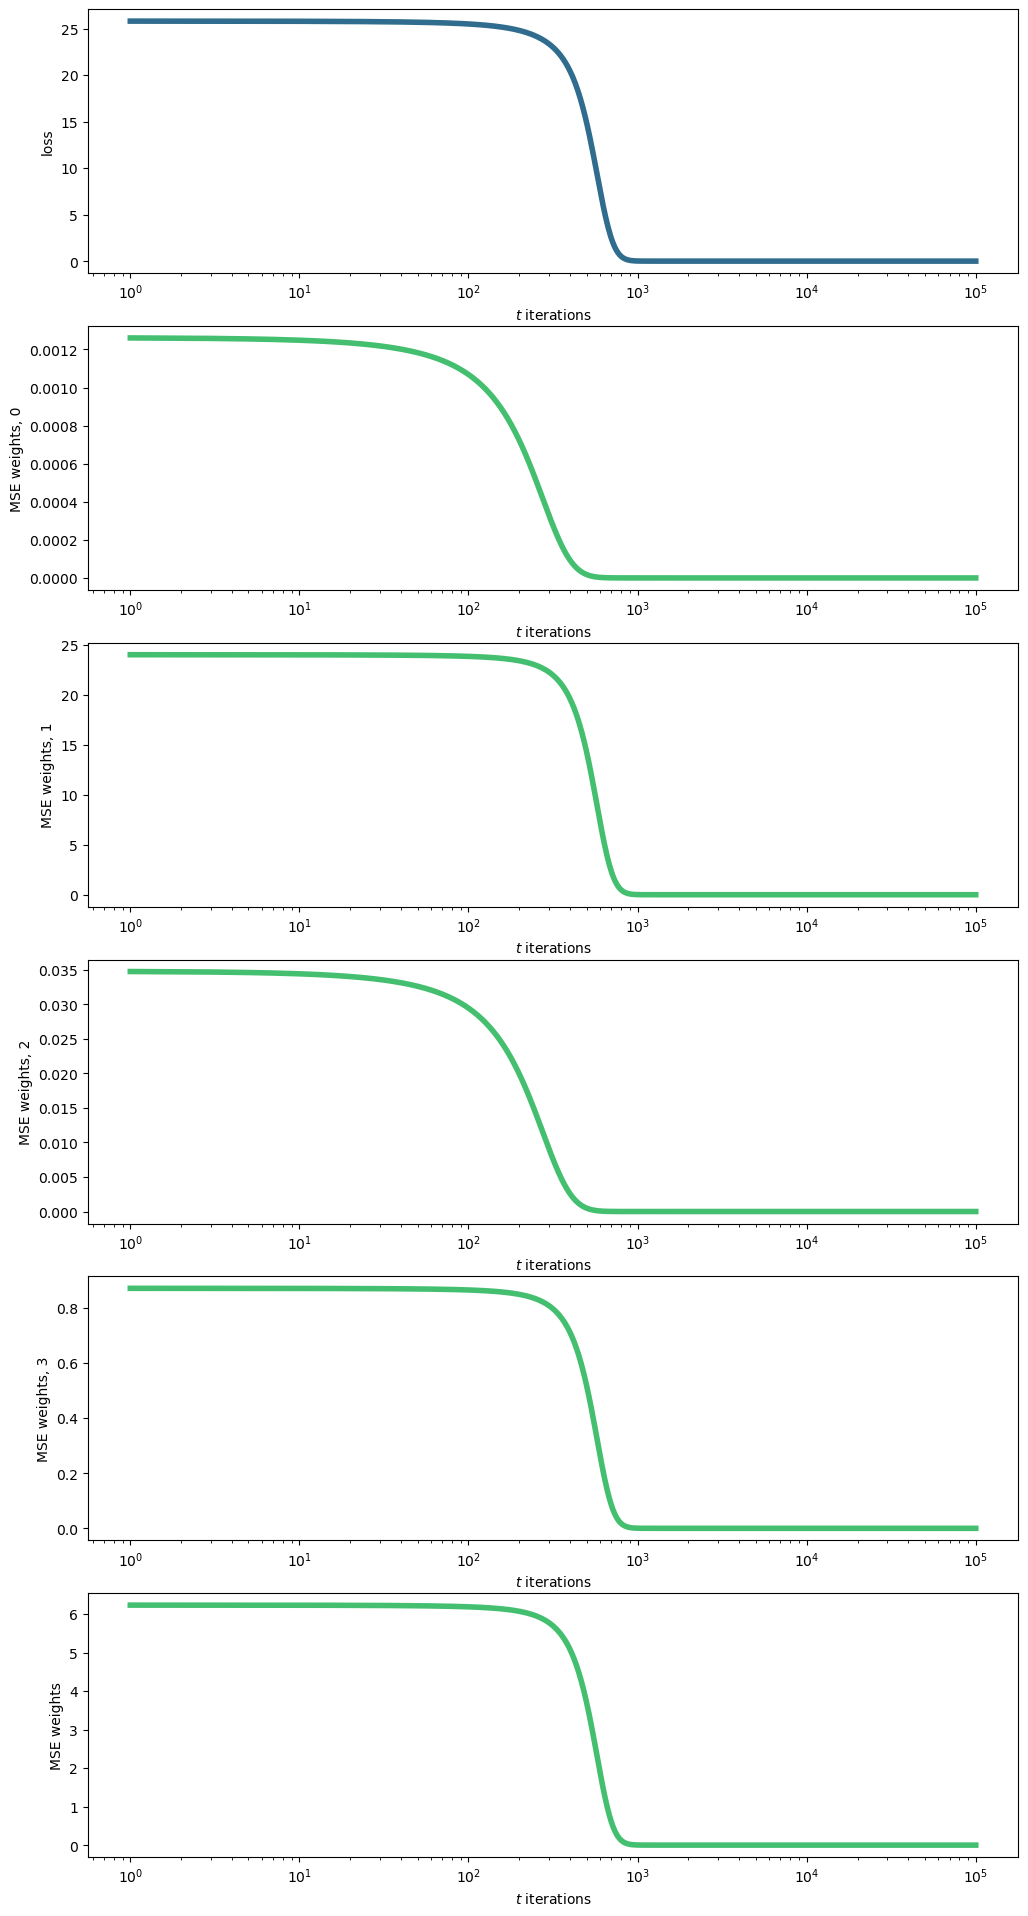

In [68]:
if synaptic:
    ws_transf = [(Uyx_tens @ w @ Vyx_tens.T) for w in ws]
    risks_w_transf = np.row_stack([((w-beta_raw)**2).reshape(-1) for w in ws_transf])
else:
    ws_transf = [(Uyx_tens.T @ w @ Vyx_tens) for w in ws] 
    risks_w_transf = np.row_stack([((w-Uyx.T @ beta_raw @ Vyx)**2).reshape(-1) for w in ws_transf])


cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(700/1000)]
labelList = ['empirical', 'theoretical']

plot_all_dims = True

num_axs = 2 + risks_w.shape[-1] if plot_all_dims else 2

fig, ax = plt.subplots(num_axs, 1, figsize=(12, 4 * num_axs))

if share_v:
    ax[0].set_xscale('log')
    ax[0].plot(geo_samples, losses[geo_samples], 
            color=colorList[1], 
            label=labelList[0],
            lw=4)

ax[0].set_ylabel('loss')
ax[0].set_xlabel(r'$t$ iterations')


if plot_all_dims:
    for i in range(risks_w.shape[-1]):
        ax[1+i].set_xscale('log')
        ax[1+i].plot(geo_samples, risks_w_transf[geo_samples, i], 
                color=colorList[2], 
                label=labelList[0],
                lw=4)

        ax[1+i].set_ylabel('MSE weights, ' + str(i))
        ax[1+i].set_xlabel(r'$t$ iterations')


ax[-1].set_xscale('log')
ax[-1].plot(geo_samples, risks_w_transf[geo_samples, :].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[0],
        lw=4)

ax[-1].set_ylabel('MSE weights')
ax[-1].set_xlabel(r'$t$ iterations')


plt.show()


## One layer, diagonal

In [ ]:
def diagonal_init_one_layer(model, X, y, Uyx, Vhyx, g_cpu, args, synaptic=False):
        
    if args.hidden > 1:
        R = torch.tensor(ortho_group.rvs(dim=args.hidden), dtype=torch.float32)
    else:
        R = torch.tensor([[1]], dtype=torch.float32)
    
    i = 0
    w_check = None
    with torch.no_grad(): 
        p, q, u = 0, 0, 0
        for m in model:
            if type(m) == torch.nn.Linear:
                
                D = torch.zeros(m.weight.data.shape, dtype=torch.float32).fill_diagonal_(1, wrap=False)
                D[D == 1] = torch.normal(mean=0, std=args.scales[0] * args.scales[1], size=(min(m.weight.data.shape[0], m.weight.data.shape[1]),), generator=g_cpu)
                    
                if synaptic: 
                    m.weight.data = D
                else:
                    m.weight.data = torch.matmul(Uyx, torch.matmul(D, Vyx.T))
                
                w_check = m.weight.data.clone()
                  
        print("Initial weight: \n {}".format(w_check))
        w_check = (Uyx.T @ w_check @ Vhyx).numpy()
        print("Transformed initial weight: \n {}".format(w_check))

        #assert np.count_nonzero(w_check - np.diag(np.diagonal(w_check))) == 0
    
    return model

In [ ]:
model = torch.nn.Sequential(
           torch.nn.Linear(args.dim, d_out, bias=False),
         ).to(device)      
                
# initialization 
synaptic = True

Sx_tens, Syx_tens = torch.tensor(np.diag(Sx), dtype=torch.float32), torch.tensor(np.diag(Syx), dtype=torch.float32)

if synaptic: 
    beta = Uyx.T @ beta_raw @ Vyx 
else:
    beta = beta_raw

g_cpu = torch.Generator()
g_cpu.manual_seed(args.seed)

Uyx_tens, Vyx_tens = torch.tensor(Uyx, dtype=torch.float32), torch.tensor(Vx, dtype=torch.float32)
model = diagonal_init_one_layer(model, Xs, ys, Uyx_tens, Vyx_tens.T, g_cpu, args, synaptic=synaptic)
 

# use same learning rate for the two layers
#if isinstance(args.lr, list):
#    stepsize = [max(args.lr)] * 2
stepsize = args.lr

In [ ]:
# train the network
losses_emp = []
mse_weights_emp = []
ws = []


for t in range(int(args.iterations)):
    
    if synaptic:
        y_pred = Xs @ torch.matmul(Uyx_tens, torch.matmul(model[0].weight,  Vyx_tens.T)).T
    else:
        y_pred = model(Xs)
   

    loss = loss_fn(y_pred, ys)
    losses_emp.append(loss.item())

    if not t % args.print_freq:
        print(t, loss.item())
        
    model.zero_grad()
    loss.backward()


    with torch.no_grad():
        i = 0
        w_tot = torch.diag(torch.ones(args.dim)) #[]
        for param in model.parameters():
                
                
            if synaptic:
                
                assert i == 0
                grad = Syx_tens - torch.matmul(model[0].weight, Sx_tens)

                param.data -= stepsize[i] * (-grad)

            else:
                param.data -= stepsize[i] * param.grad
                                
            w_tot = w_tot @ param.data.t()
            if len(param.shape) > 1:
                i += 1
        
        w_tot = w_tot.squeeze()
        ws.append(w_tot)
        assert w_tot.shape == beta.squeeze().shape
        mse_weights_emp.append((w_tot-beta.squeeze())**2)


In [ ]:
losses = np.array(losses_emp)
risks_w = np.row_stack([mse_w.reshape(-1) for mse_w in mse_weights_emp])

#ws_transf = [(Uyx @ w.T @ Vhyx).T for w in ws]
#risks_w_transf = np.row_stack([((w-beta)**2).reshape(-1) for w in ws_transf])

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(700/1000)]
labelList = ['empirical', 'theoretical']

plot_all_dims = True

num_axs = 2 + risks_w.shape[-1] if plot_all_dims else 2

fig, ax = plt.subplots(num_axs, 1, figsize=(12, 4 * num_axs))


ax[0].set_xscale('log')
ax[0].plot(geo_samples, losses[geo_samples], 
        color=colorList[1], 
        label=labelList[0],
        lw=4)

ax[0].set_ylabel('loss')
ax[0].set_xlabel(r'$t$ iterations')


if plot_all_dims:
    for i in range(risks_w.shape[-1]):
        ax[1+i].set_xscale('log')
        ax[1+i].plot(geo_samples, risks_w[geo_samples, i], 
                color=colorList[2], 
                label=labelList[0],
                lw=4)

        ax[1+i].set_ylabel('MSE weights, ' + str(i))
        ax[1+i].set_xlabel(r'$t$ iterations')


ax[-1].set_xscale('log')
ax[-1].plot(geo_samples, risks_w[geo_samples, :].mean(axis=-1), 
        color=colorList[2], 
        label=labelList[0],
        lw=4)

ax[-1].set_ylabel('MSE weights')
ax[-1].set_xlabel(r'$t$ iterations')


plt.show()

## Weight comp.

In [ ]:
print("Final weights:")
print(ws[-1]) 

if synaptic:
    print(f"Global minimum: \n {beta}")
    print(f"Transformed final weights (true space): \n {Uyx_tens@ws[-1]@Vyx_tens.T}")
    print(f"Transformed global minimum (true space): \n {Uyx_tens @ Syx_tens @ Vyx_tens.T @ torch.inverse(Xs.T @ Xs)}")
    
    if share_v:
        print(f"Final loss: {loss_fn(Xs @ (Uyx_tens@ws[-1].T@Vyx_tens.T).T, ys)}")
else:
    print(f"Global minimum: \n {ys.T @ Xs @ torch.inverse(Xs.T @ Xs)}")
    print(f"Transformed final weights (synaptic weight space): \n {Uyx_tens.T@ws[-1]@Vyx_tens}")
    print(f"Transformed global minimum (synaptic weight space): \n {np.diag(Sw)}")
    print(f"Final loss: \n {loss_fn(Xs @ ws[-1].T, ys)}")

if share_v:
    print(f"Loss of global minimum: \n {loss_fn(Xs @ (ys.T @ Xs @ torch.inverse(Xs.T @ Xs)).T, ys)}")
